# Noise Conditional Score Network

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision
from torch.utils import data
from torchvision.utils import save_image, make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import yaml
import os
import argparse
import numpy as np
from tqdm.autonotebook import tqdm
from PIL import Image
from model.scorenet import CondRefineNetDilated
from model.langevindynamics import anneal_Langevin_dynamics
from runners.utils import mkdir

In [2]:
def show_images(imgs, num_rows, num_cols, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    return axes

## 1.显示数据集数据

In [3]:
trans = transforms.ToTensor()
fashion_mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
fashion_mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)
mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=trans, download=True)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

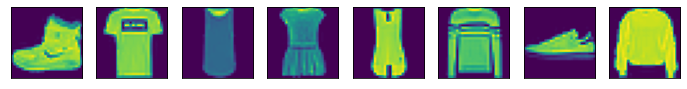

In [4]:
X, y = next(iter(data.DataLoader(fashion_mnist_train, batch_size=8)))
show_images(X.reshape(8, 28, 28), 1, 8)

## 2. score-matching 最大 sigma 和最小 sigma 效果

In [5]:
def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace

config = None
with open('./configs/NCSN.yml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2namespace(config)
config.device = torch.device('cuda:0')

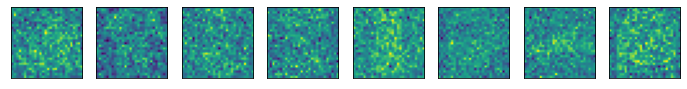

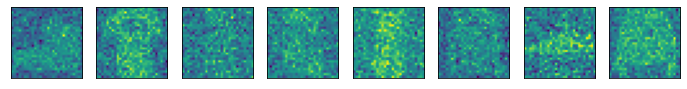

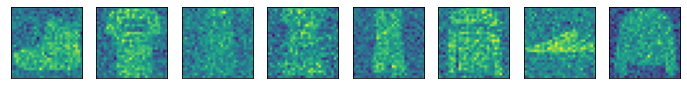

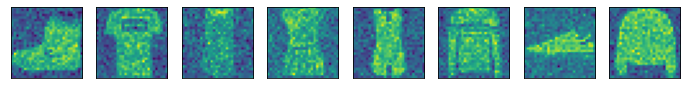

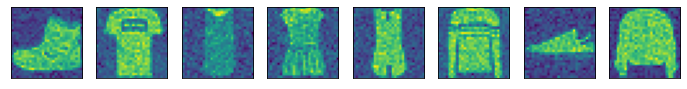

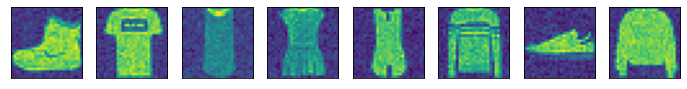

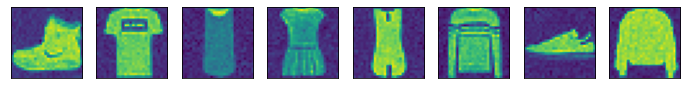

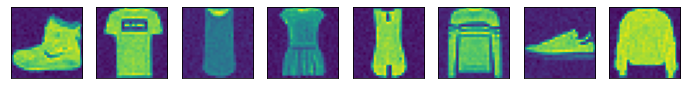

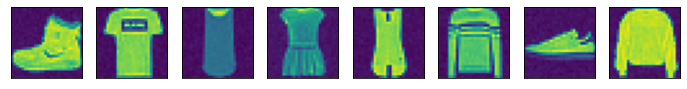

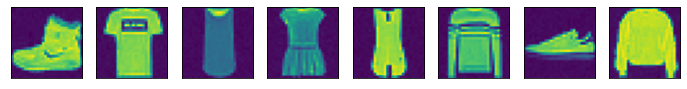

In [6]:
X = X.to(config.device)
sigmas = torch.tensor(np.exp(np.linspace(np.log(config.model.sigma_begin), 
                                         np.log(config.model.sigma_end),
                                         config.model.num_classes))).float().to(config.device)
for sigma in sigmas:
    perturbed_X = X + torch.randn_like(X) * sigma
    show_images(perturbed_X.reshape(8, 28, 28).cpu(), 1, 8)

## 3. NCSN减噪过程

In [7]:
scorenet = CondRefineNetDilated(config).to(config.device)
states = torch.load('./output/NCSN/model/checkpoint.pth')
scorenet.load_state_dict(states[0])

<All keys matched successfully>

In [8]:
mkdir('./jupyter samples/NCSN samples')

def save_sample_img(all_samples, subpath):
    imgs = []
    sample_path = './jupyter samples/NCSN samples'
    sample_path = os.path.join(sample_path, subpath)
    mkdir(sample_path)
    
    for i, sample in enumerate(tqdm(all_samples, total=len(all_samples), desc='saving images')):
        sample = sample.view(grid_size ** 2, config.data.channels, config.data.image_size,
                                config.data.image_size)

        image_grid = make_grid(sample, nrow=grid_size)
        if i % 10 == 0:
            im = Image.fromarray(
                image_grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy())
            imgs.append(im)

        if i % 50 == 0:
            save_image(image_grid, os.path.join(sample_path, 'image_{}.png'.format(i)))
        imgs[0].save(os.path.join(sample_path, "movie.gif"), save_all=True, append_images=imgs[1:],
                    duration=1, loop=0)

### 从随机噪声采样

In [9]:
grid_size = 4
random_samples = torch.rand(grid_size ** 2, 1, 28, 28, device=config.device)
all_samples = anneal_Langevin_dynamics(random_samples, scorenet, sigmas, 100, 0.00002)
save_sample_img(all_samples, 'random_sample_1')

annealed Langevin dynamics sampling: 100%|██████| 10/10 [00:21<00:00,  2.10s/it]


saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

<img src="./jupyter samples/NCSN samples/random_sample_1/movie.gif" width=250 align="left">

#### 同一个噪声采样两次

In [10]:
all_samples = anneal_Langevin_dynamics(random_samples, scorenet, sigmas, 100, 0.00002)
save_sample_img(all_samples, 'random_sample_2')

annealed Langevin dynamics sampling: 100%|██████| 10/10 [00:21<00:00,  2.11s/it]


saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

<img src="./jupyter samples/NCSN samples/random_sample_2/movie.gif" width=250 align="left">

### 从训练集数据采样

annealed Langevin dynamics sampling: 100%|██████| 10/10 [00:21<00:00,  2.19s/it]


saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

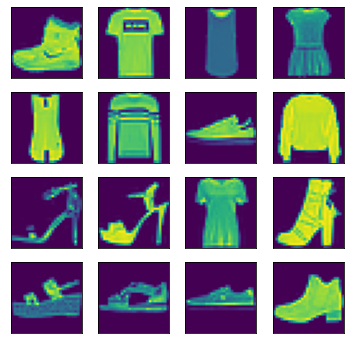

In [11]:
X, y = next(iter(data.DataLoader(fashion_mnist_train, batch_size=16)))
show_images(X.reshape(16, 28, 28), 4, 4)
X = X.to(config.device)
perturbed_samples = X + torch.randn_like(X) * config.model.sigma_begin
all_samples = anneal_Langevin_dynamics(random_samples, scorenet, sigmas, 100, 0.00002)
save_sample_img(all_samples, 'train_perturb_sample')

<img src="./jupyter samples/NCSN samples/train_perturb_sample/movie.gif" width=250 align="left">

### 从测试集数据采样

annealed Langevin dynamics sampling: 100%|██████| 10/10 [00:21<00:00,  2.17s/it]


saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

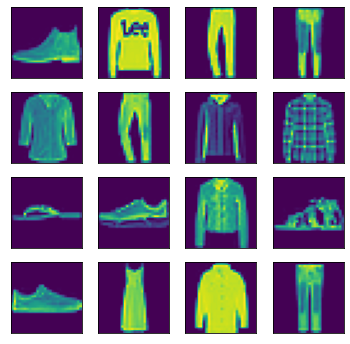

In [12]:
test_X, test_y = next(iter(data.DataLoader(fashion_mnist_test, batch_size=16)))
show_images(test_X.reshape(16, 28, 28), 4, 4)
test_X = test_X.to(config.device)
perturbed_samples = test_X + torch.randn_like(test_X) * config.model.sigma_begin
all_samples = anneal_Langevin_dynamics(random_samples, scorenet, sigmas, 100, 0.00002)
save_sample_img(all_samples, 'test_perturb_sample')

<img src="./jupyter samples/NCSN samples/test_perturb_sample/movie.gif" width=250 align="left">

### 从其他数据集采样

annealed Langevin dynamics sampling: 100%|██████| 10/10 [00:21<00:00,  2.11s/it]


saving images:   0%|          | 0/1000 [00:00<?, ?it/s]

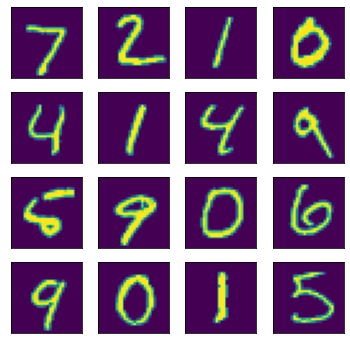

In [13]:
test_X, test_y = next(iter(data.DataLoader(mnist_test, batch_size=16)))
show_images(test_X.reshape(16, 28, 28), 4, 4)
test_X = test_X.to(config.device)
perturbed_samples = test_X + torch.randn_like(test_X) * config.model.sigma_begin
all_samples = anneal_Langevin_dynamics(random_samples, scorenet, sigmas, 100, 0.00002)
save_sample_img(all_samples, 'unrelated_perturb_sample')

<img src="./jupyter samples/NCSN samples/unrelated_perturb_sample/movie.gif" width=250 align="left">

torch.Size([16, 1, 28, 28])


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

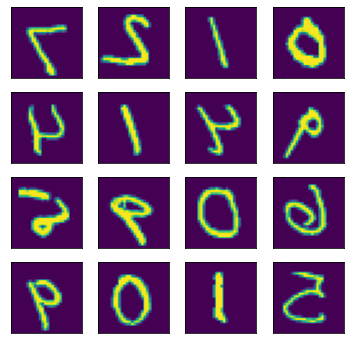

In [18]:
test_X = test_X.to('cpu')
transform = transforms.RandomHorizontalFlip(p=1.0)
test_X = transform(test_X)
print(test_X.shape)
show_images(test_X.reshape(16, 28, 28), 4, 4)